In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
import torch
from torch import nn

device= "cuda" if torch.cuda.is_available() else "cpu"


In [ ]:
import pandas as pd
import numpy as np

data =  pd.read_csv('drive/MyDrive/transactions_train.csv')
print(data.iloc[0].values)
data1 = data[data['type'] == 'TRANSFER']
data2= data[data['type'] == 'CASH_OUT']
X1=data1[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']].values
y1=data1.iloc[:,9].values
X2=data2[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']].values
y2=data2.iloc[:,9].values
print(data.shape)

[1 'PAYMENT' 9839.64 'C1231006815' 170136.0 160296.36 'M1979787155' 0.0
 0.0 0 0]
(6362620, 11)


In [ ]:
from sklearn.model_selection import train_test_split

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1,stratify=y1 , test_size=0.30, random_state=42)
X1_val, X1_test, y1_val, y1_test = train_test_split(X1_test, y1_test,stratify=y1_test , test_size=0.50, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2,stratify=y2 , test_size=0.30, random_state=42)
X2_val, X2_test, y2_val, y2_test = train_test_split(X2_test, y2_test,stratify=y2_test , test_size=0.50, random_state=42)

In [ ]:
import torch
X1_train = torch.Tensor(X1_train).to('cuda')
X1_val = torch.Tensor(X1_val).to('cuda')
X2_train = torch.Tensor(X2_train).to('cuda')
X2_val = torch.Tensor(X2_val).to('cuda')
y1_train = torch.Tensor(y1_train).to('cuda')
y1_val = torch.Tensor(y1_val).to('cuda')
y2_train = torch.Tensor(y2_train).to('cuda')
y2_val = torch.Tensor(y2_val).to('cuda')

In [ ]:
tar=[]
for i in y1_train:
  if(i==0):
    tar.append([1,0])
  else:
    tar.append([0,1])

tar=torch.Tensor(tar).to('cuda')

var=[]
for i in y1_val:
  if(i==0):
    var.append([1,0])
  else:
    var.append([0,1])

var=torch.Tensor(var).to('cuda')


In [ ]:
from torch.utils.data.dataset import TensorDataset
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.metrics import precision_recall_fscore_support as score
import sklearn
print(sklearn.__version__)

class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(5 , 4),
      nn.Sigmoid(),
      nn.Linear(4, 2),
      nn.Softmax(),
      
    )
  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)
  
  
if __name__ == '__main__':
  wt = [i*100 + 100 for i in range(50)]
  plist = []
  flist = []
  rlist = []
  wlist =[]
  for w in wt:
    torch.manual_seed(42)
    mlp = MLP().to('cuda')
    weight=torch.tensor([2., w]).to('cuda')
    loss_function = nn.CrossEntropyLoss(weight=weight)
    optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-2)
    
    for epoch in range(0, 500):  
      current_loss = 0.0
      inputs, targets = X1_train,tar
      inputs=inputs.to('cuda')
      targets=targets.to('cuda')
      optimizer.zero_grad()
      outputs = mlp(inputs.to('cuda')).to('cuda')
      loss = loss_function(outputs.to('cuda'), targets.to('cuda')).to('cuda')
      loss.backward()
      optimizer.step()
      current_loss += loss.item()
      # print(current_loss)
    print('Training process has finished.')
    # preds = [0 if i[0]>0.5 else 1 for i in outputs]
    inputs_val, targets_val = X1_val,var
    inputs_val=inputs_val.to('cuda')
    targets_val=targets_val.to('cuda')
    outputs_val = mlp(inputs_val.to('cuda')).to('cuda')
    preds_val = [0 if i[0]>0.5 else 1 for i in outputs_val]
    precision, recall, fscore, support=score(y1_val.to('cpu'),preds_val, average=None)
    print(precision[1], recall[1], fscore[1])
    if precision[1] > 0.1:
      wlist.append(w)
      plist.append(precision[1])
      flist.append(fscore[1])
      rlist.append(recall[1])

1.1.3


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.0 0.0 0.0
Training process has finished.
0.9805825242718447 0.9869706840390879 0.9837662337662338


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.0076884547958928125 1.0 0.015259586947337027


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.9916943521594684 0.9723127035830619 0.9819078947368421


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.007681144915932746 1.0 0.015245189323401616
Training process has finished.
0.9852700490998363 0.9804560260586319 0.9828571428571429


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.007681144915932746 1.0 0.015245189323401616
Training process has finished.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.007681144915932746 1.0 0.015245189323401616
Training process has finished.
0.9916943521594684 0.9723127035830619 0.9819078947368421


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.8792341678939617 0.9723127035830619 0.9234338747099767


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.9916943521594684 0.9723127035830619 0.9819078947368421


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.9558359621451105 0.9869706840390879 0.9711538461538461


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.9916943521594684 0.9723127035830619 0.9819078947368421


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.9900497512437811 0.9723127035830619 0.981101068200493


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.9820554649265906 0.9804560260586319 0.9812550937245313


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.861671469740634 0.9739413680781759 0.9143730886850153


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.1068498037816625 0.9755700325732899 0.19260450160771703


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.9916943521594684 0.9723127035830619 0.9819078947368421


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.9326186830015314 0.99185667752443 0.9613259668508287


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.45884146341463417 0.9804560260586319 0.6251298026998962


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.9916943521594684 0.9723127035830619 0.9819078947368421


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.9933333333333333 0.9706840390879479 0.9818780889621088


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.9916805324459235 0.9706840390879479 0.9810699588477366


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.3032911392405063 0.9755700325732899 0.46272692159134804


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.9966555183946488 0.9706840390879479 0.9834983498349834


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.2652972027972028 0.988599348534202 0.41833218470020683


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.4298056155507559 0.9723127035830619 0.5961058412381428


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.9215384615384615 0.9755700325732899 0.9477848101265823


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.9884297520661157 0.9739413680781759 0.9811320754716981


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.22916666666666666 0.9853420195439739 0.3718500307314075


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.48936170212765956 0.9739413680781759 0.6514161220043573


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.9354838709677419 0.99185667752443 0.9628458498023715


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.9025487256371814 0.9804560260586319 0.9398907103825136


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.6681564245810055 0.9739413680781759 0.7925778661365142


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.7044392523364486 0.9820846905537459 0.8204081632653061


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.9710144927536232 0.9820846905537459 0.9765182186234818


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.007681144915932746 1.0 0.015245189323401616
Training process has finished.
0.2383399209486166 0.9820846905537459 0.383587786259542


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.6437768240343348 0.9771986970684039 0.7761966364812419


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.9916943521594684 0.9723127035830619 0.9819078947368421


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.6806818181818182 0.9755700325732899 0.8018741633199464


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.966824644549763 0.996742671009772 0.9815557337610266


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.6113886113886113 0.996742671009772 0.7578947368421053


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.9900826446280991 0.9755700325732899 0.9827727645611156


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.9884297520661157 0.9739413680781759 0.9811320754716981


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.9933333333333333 0.9706840390879479 0.9818780889621088


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.6167355371900827 0.9723127035830619 0.754740834386852


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.287776708373436 0.9739413680781759 0.4442793462109956


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.9933333333333333 0.9706840390879479 0.9818780889621088


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.9588607594936709 0.9869706840390879 0.9727126805778492


In [ ]:
preds = [0 if i[0]>0.5 else 1 for i in outputs]

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support=score(y1_train.to('cpu'),preds)
print(precision, recall, fscore)

[0.         0.00768827] [0. 1.] [0.         0.01525922]


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


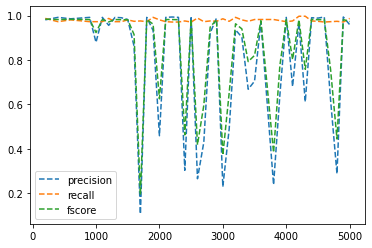

In [ ]:
import matplotlib.pyplot as plt
plt.plot(wlist,plist,label = "precision",linestyle="--")
plt.plot(wlist,rlist,label = "recall",linestyle="--")
plt.plot(wlist,flist,label = "fscore",linestyle="--")
plt.legend()
# plt.show()
plt.savefig('mlp_fraud')

In [ ]:
tar=[]
y1_train = y2_train
X1_train = X2_train
y1_val = y2_val
X1_val = X2_val
for i in y1_train:
  if(i==0):
    tar.append([1,0])
  else:
    tar.append([0,1])

tar=torch.Tensor(tar).to('cuda')

var=[]
for i in y1_val:
  if(i==0):
    var.append([1,0])
  else:
    var.append([0,1])

var=torch.Tensor(var).to('cuda')


In [ ]:
from torch.utils.data.dataset import TensorDataset
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.metrics import precision_recall_fscore_support as score
import sklearn
print(sklearn.__version__)

class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(5 , 4),
      nn.Sigmoid(),
      nn.Linear(4, 2),
      nn.Softmax(),
      
    )
  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)
  
  
if __name__ == '__main__':
  wt = [i*100 + 100 for i in range(50)]
  plist = []
  flist = []
  rlist = []
  wlist =[]
  for w in wt:
    torch.manual_seed(42)
    mlp = MLP().to('cuda')
    weight=torch.tensor([2., w]).to('cuda')
    loss_function = nn.CrossEntropyLoss(weight=weight)
    optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-2)
    
    for epoch in range(0, 500):  
      current_loss = 0.0
      inputs, targets = X1_train,tar
      inputs=inputs.to('cuda')
      targets=targets.to('cuda')
      optimizer.zero_grad()
      outputs = mlp(inputs.to('cuda')).to('cuda')
      loss = loss_function(outputs.to('cuda'), targets.to('cuda')).to('cuda')
      loss.backward()
      optimizer.step()
      current_loss += loss.item()
      # print(current_loss)
    print('Training process has finished.')
    # preds = [0 if i[0]>0.5 else 1 for i in outputs]
    inputs_val, targets_val = X1_val,var
    inputs_val=inputs_val.to('cuda')
    targets_val=targets_val.to('cuda')
    outputs_val = mlp(inputs_val.to('cuda')).to('cuda')
    preds_val = [0 if i[0]>0.5 else 1 for i in outputs_val]
    precision, recall, fscore, support=score(y1_val.to('cpu'),preds_val, average=None)
    print(precision[1], recall[1], fscore[1])
    if precision[1] > 0.1:
      wlist.append(w)
      plist.append(precision[1])
      flist.append(fscore[1])
      rlist.append(recall[1])

1.1.3


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.0 0.0 0.0
Training process has finished.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.0 0.0 0.0
Training process has finished.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.0 0.0 0.0
Training process has finished.
0.10994912379875636 0.6294498381877023 0.18719923002887393


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.0 0.0 0.0
Training process has finished.
0.038762137838477935 0.7944983818770227 0.0739179525780956


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.03733752071883451 0.6925566343042071 0.07085506166708054


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.0 0.0 0.0
Training process has finished.
0.0 0.0 0.0


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.03089216056373474 0.7944983818770227 0.059471899224806196


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.04051172707889126 0.7378640776699029 0.07680646791308741


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.001841340782122905 1.0 0.003675912955808745
Training process has finished.
0.0666563323515734 0.6957928802588996 0.12165794313198472


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.021933319354162296 0.8462783171521036 0.04275845153905898


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.01744186046511628 0.8737864077669902 0.03420102603078092


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.001841340782122905 1.0 0.003675912955808745
Training process has finished.
0.023045398903613817 0.7006472491909385 0.04462307414850312


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.001841340782122905 1.0 0.003675912955808745
Training process has finished.
0.0020647608542863965 0.9935275080906149 0.004120957485007836


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.0023971531362427657 0.9919093851132686 0.004782747778323933


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.002014614155453403 0.9935275080906149 0.004021074622369355


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.00255893494785961 0.9902912621359223 0.005104679289348569


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.030339271102158998 0.7799352750809061 0.05840654347167526


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.002339805270277995 0.9935275080906149 0.004668615725023096


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.026356848322746016 0.7653721682847896 0.05095884507649214


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.002191226514913209 0.9919093851132686 0.004372793094838963


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.0022344416989035225 0.9935275080906149 0.004458855439404228


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.017 0.9077669902912622 0.03337497769052294


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.001841340782122905 1.0 0.003675912955808745
Training process has finished.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.001841340782122905 1.0 0.003675912955808745
Training process has finished.
0.0022863015534934986 0.9935275080906149 0.00456210480952841


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.00282274802822748 0.9902912621359223 0.005629449748882388


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.001841340782122905 1.0 0.003675912955808745
Training process has finished.
0.04474921630094044 0.9239482200647249 0.08536403049783227


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.027076004690331522 0.8220064724919094 0.05242518059855521


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.0023645403804094167 0.9919093851132686 0.004717834260096589


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.001841340782122905 1.0 0.003675912955808745
Training process has finished.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.001841340782122905 1.0 0.003675912955808745
Training process has finished.
0.0022335946007217373 0.9724919093851133 0.004456952586478599


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.001985704216966346 0.9983818770226537 0.0039635252891542655


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.
0.0019742925984826427 0.9983818770226537 0.003940792310026028


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training process has finished.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.001841340782122905 1.0 0.003675912955808745
Training process has finished.


In [ ]:
preds = [0 if i[0]>0.5 else 1 for i in outputs]

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support=score(y1_train.to('cpu'),preds)
print(precision, recall, fscore)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(wlist,plist,label = "precision",linestyle="--")
plt.plot(wlist,rlist,label = "recall",linestyle="--")
plt.plot(wlist,flist,label = "fscore",linestyle="--")
plt.legend()
# plt.show()
plt.savefig('mlp_fraud')